Getting usefull data using eurostat package

In [1]:
import eurostat

# Dataset 	GERD by sector of performance and socioeconomic objectives rd_e_gerdsobj92
# sectperf: TOTAL All sectors
# sectperf: BES Business enterprise sector
# sectperf: GVT Government sector
# sectperf: HES Higher education sector
# sectperf: PNP Private non-profit sector

# unit = unit of measure
# EUR_HAB = Euro per inhabitant
# MIO_EUR = Million Euro
# MIO_PPS = Million Purchasing Power Standard
# MIO_PPS_KP05 = Million Purchasing Power Standard per capita, 2005 prices

# geo = country
# EU27_2020 = European Union (27 countries)
# EA20 = Euro area (20 countries)

# Available flags:
# (e) estimated
# (p) provisional
# (d) definition differs (see metadata)
# (bd) break in time series, definition differs (see metadata)
# (b) break in time series
# (de) definition differs (see metadata), estimated
# (dp) definition differs (see metadata), provisional
# (ep) estimated, provisional
# (bp) break in time series, provisional
# (u) low reliability



RD_EXP_BY_SECTOR = eurostat.get_data_df("rd_e_gerdtot",True)
print(RD_EXP_BY_SECTOR.head())
print(RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique())

countries = RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique()

#Patent applications https://ec.europa.eu/eurostat/databrowser/view/pat_ep_ntot/default/table?lang=en&category=scitech.ipr.pat.pat_h
PAT_APPLICATIONS_HIST = eurostat.get_data_df("pat_ep_ntot",True)
PAT_APPLICATIONS_NEW = eurostat.get_data_df("pat_ep_tot",True)

print(PAT_APPLICATIONS_HIST.head())

  freq sectperf     unit geo\TIME_PERIOD  1980_value 1980_flag  1981_value  \
0    A      BES  EUR_HAB              AT         NaN         :      51.466   
1    A      BES  EUR_HAB              BA         NaN         :         NaN   
2    A      BES  EUR_HAB              BE         NaN         :      92.121   
3    A      BES  EUR_HAB              BG         NaN         :         NaN   
4    A      BES  EUR_HAB              CH         NaN         :     226.259   

  1981_flag  1982_value 1982_flag  ...  2019_value 2019_flag  2020_value  \
0         d         NaN         :  ...     987.624               953.084   
1         :         NaN         :  ...       3.419                 3.630   
2                95.968            ...     972.758              1001.321   
3         :         NaN         :  ...      51.644                53.788   
4                   NaN         :  ...    1629.766                   NaN   

  2020_flag  2021_value 2021_flag  2022_value 2022_flag  2023_value 2023_f

Add a variable to check for timea specific timespan.
Per county of origin. 

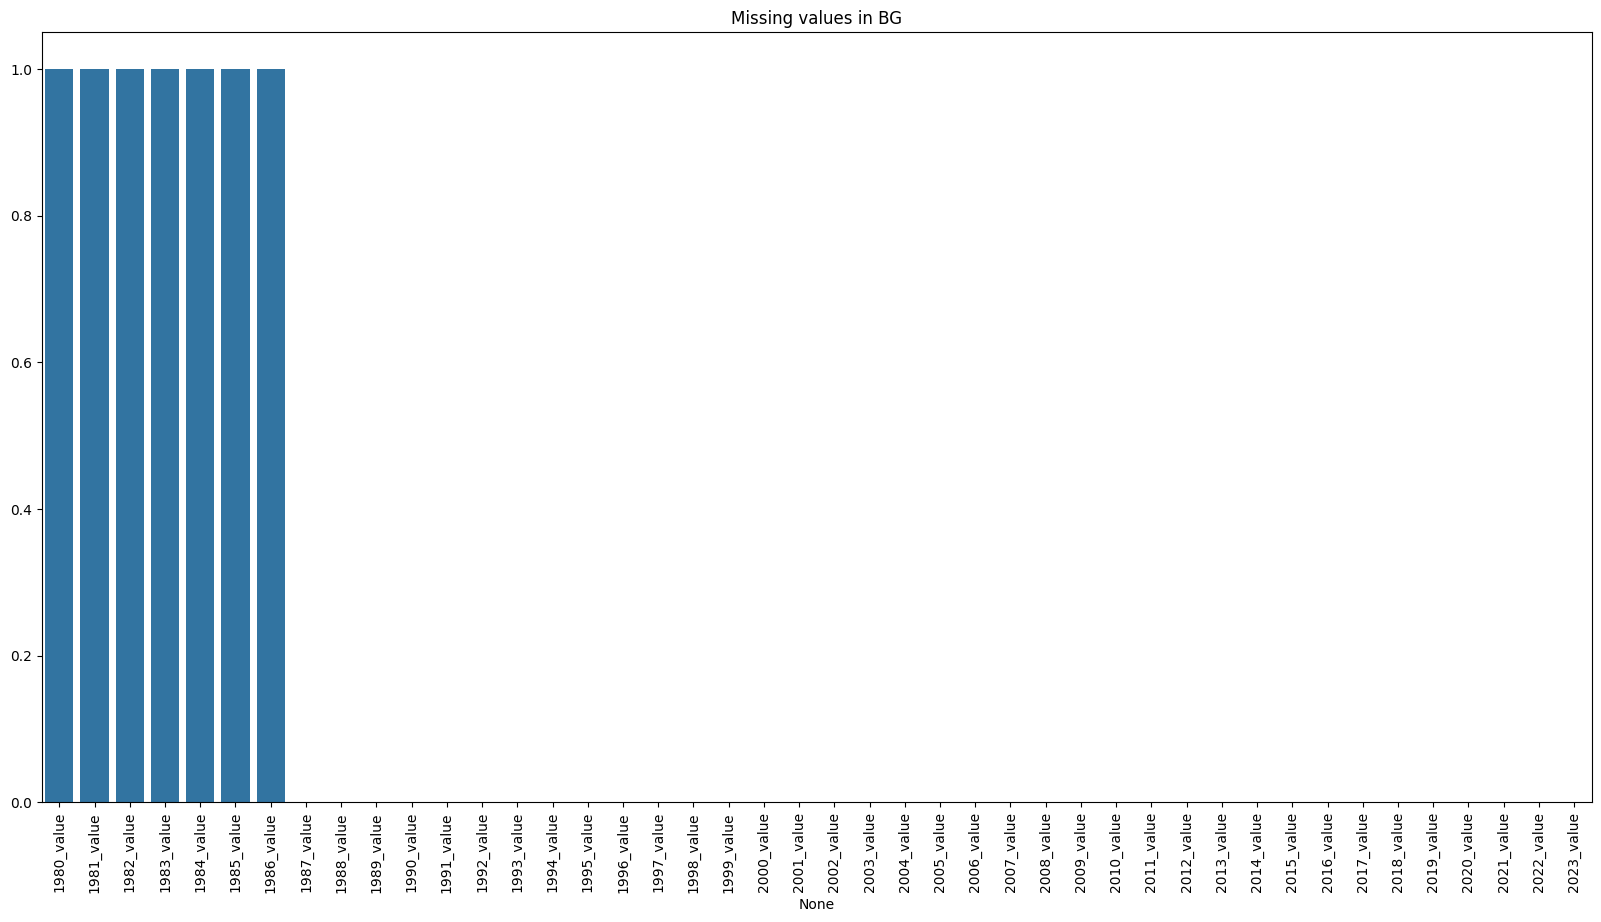

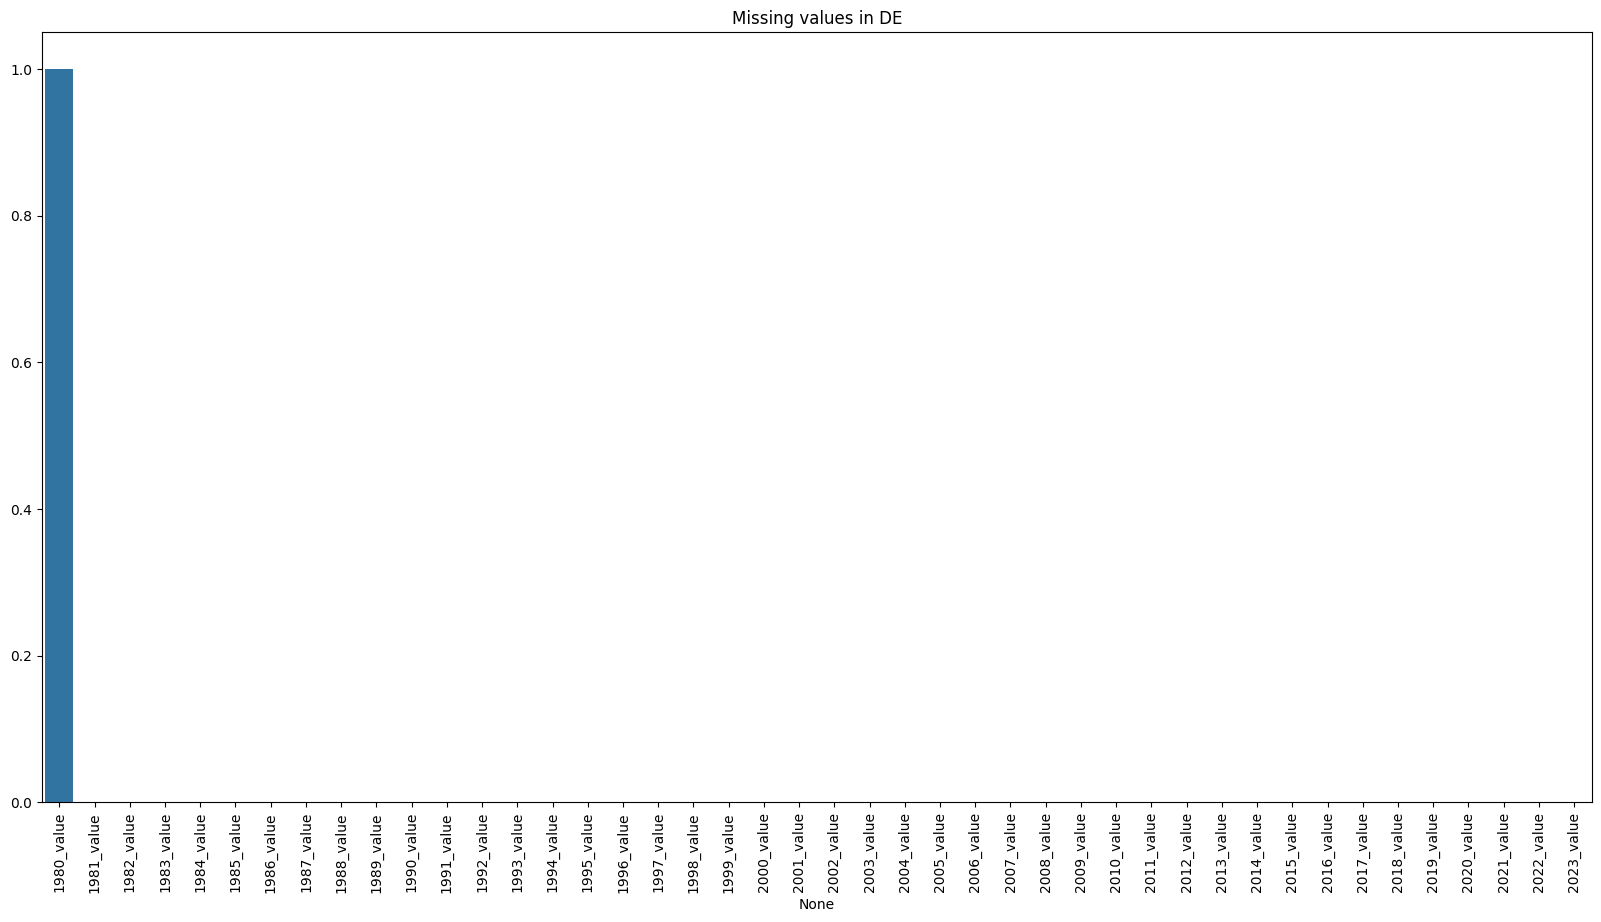

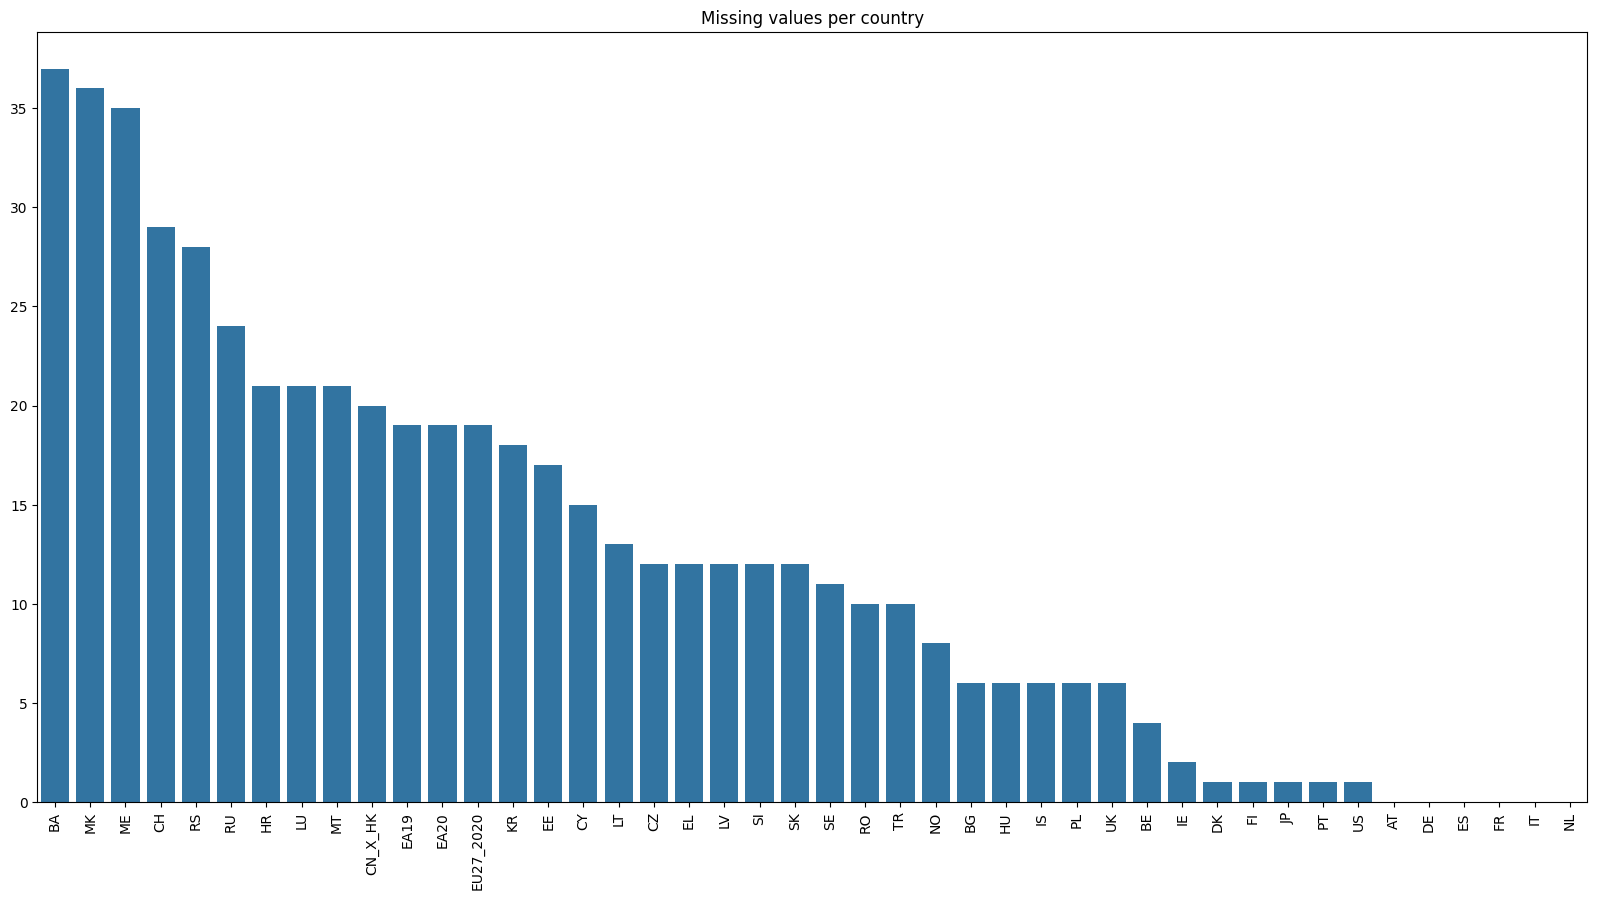

In [2]:
time_span = 43 # max timespan =43 current year - time_span
sector = "TOTAL" # All sectors
unit = "EUR_HAB" # Euro per inhabitant
# access the data this can be accessed like [-2*time_span:] but the first 4 columns should also be kepped since they have valueable information
import seaborn as sns
import matplotlib.pyplot as plt

dataBySector = RD_EXP_BY_SECTOR[(RD_EXP_BY_SECTOR["sectperf"] == sector) & (RD_EXP_BY_SECTOR["unit"] == unit)]
missingData = {}
# check for missing values per country

def getMissingDataForTimespan(dataBySector,time_span,plotCountries):
    missingData = {}
    for country in countries:
        country_data = dataBySector[dataBySector["geo\TIME_PERIOD"] == country]
        missing_values = country_data.isnull().sum()
        missing_values = missing_values[missing_values.index.str.contains(r'\d{4}_value')]
        missingData[country] = sum(missing_values[-time_span:])
        if country in plotCountries:
            plt.figure(figsize=(20,10))
            sns.barplot(x=missing_values.index,y=missing_values.values)
            plt.xticks(rotation=90)
            plt.title("Missing values in "+country)
            plt.show()
    return missingData

missingData = getMissingDataForTimespan(dataBySector,time_span,["DE","BG"])
# plot the distribution of missing values per country
#sort the values by the number of missing values
missingData = dict(sorted(missingData.items(), key=lambda item: item[1],reverse=True))
plt.figure(figsize=(20,10))
sns.barplot(x=missingData.keys(),y=missingData.values())
plt.xticks(rotation=90)
plt.title("Missing values per country")
plt.show()

    

Find the timespan where got the most data to support the analysis.

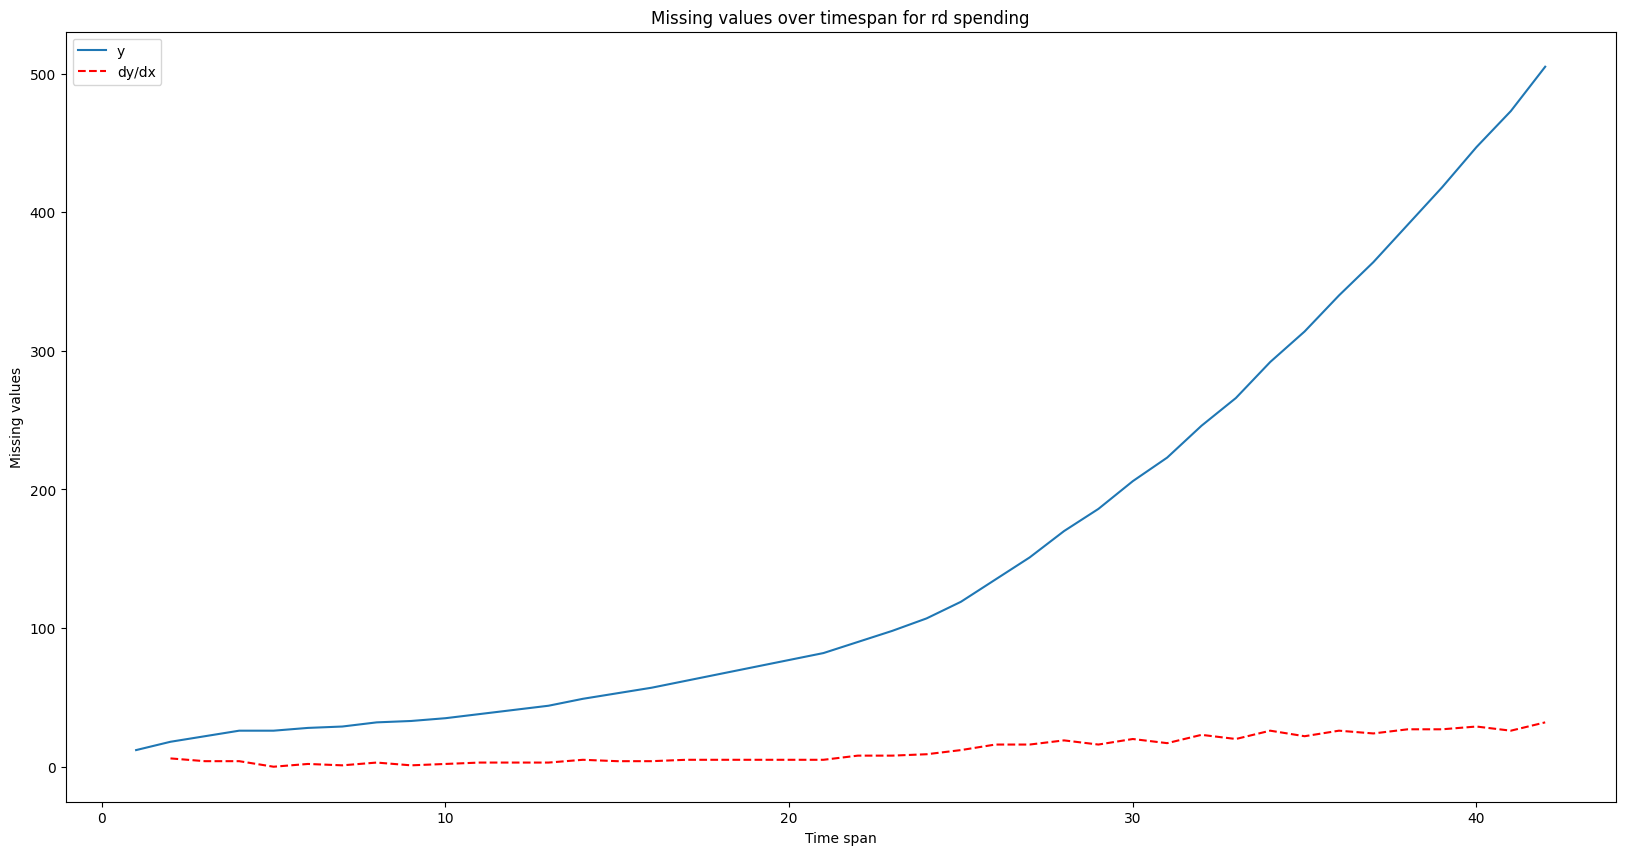

   x   y  y_total  rel_missing_values  dy/dx
0  1  12       44            0.272727    NaN
1  2  18       88            0.204545    6.0
2  3  22      132            0.166667    4.0
3  4  26      176            0.147727    4.0
4  5  26      220            0.118182    0.0


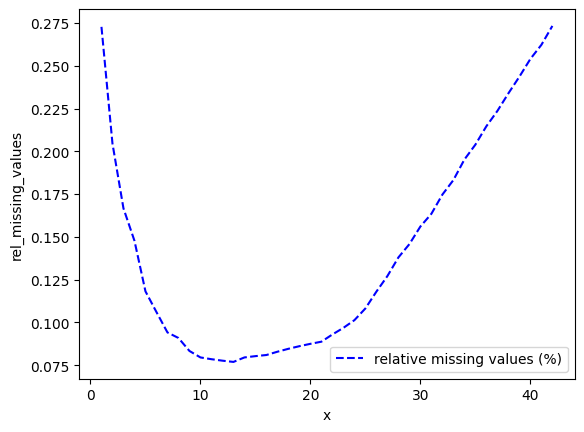

In [3]:
import pandas as pd
plotData = pd.DataFrame()
#add columns x and y
plotData["x"] = range(1, 43)
plotData["y"] = [sum(getMissingDataForTimespan(dataBySector, time_span, []).values()) for time_span in range(1, 43)]
#plotData["total_y"] = [sum(dataBySector.)]
plotData["y_total"] = [time_span * len(RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique()) for time_span in range(1, 43)]
plotData["rel_missing_values"] = plotData["y"] / plotData["y_total"]


# Calculate the derivative (numerical approximation)
plotData["dy/dx"] = plotData["y"].diff()

# Plotting the data and its derivative
plt.figure(figsize=(20, 10))

# Plot the original data
sns.lineplot(data=plotData, x="x", y="y", label="y")

# Plot the derivative
sns.lineplot(data=plotData, x="x", y="dy/dx", label="dy/dx", linestyle="--", color="red")




plt.xlabel("Time span")
plt.ylabel("Missing values")
plt.title("Missing values over timespan for rd spending")
plt.legend()
plt.show()

print(plotData.head())
sns.lineplot(data=plotData, x="x", y="rel_missing_values", label="relative missing values (%)", linestyle="--", color="blue")
plt.show()

    

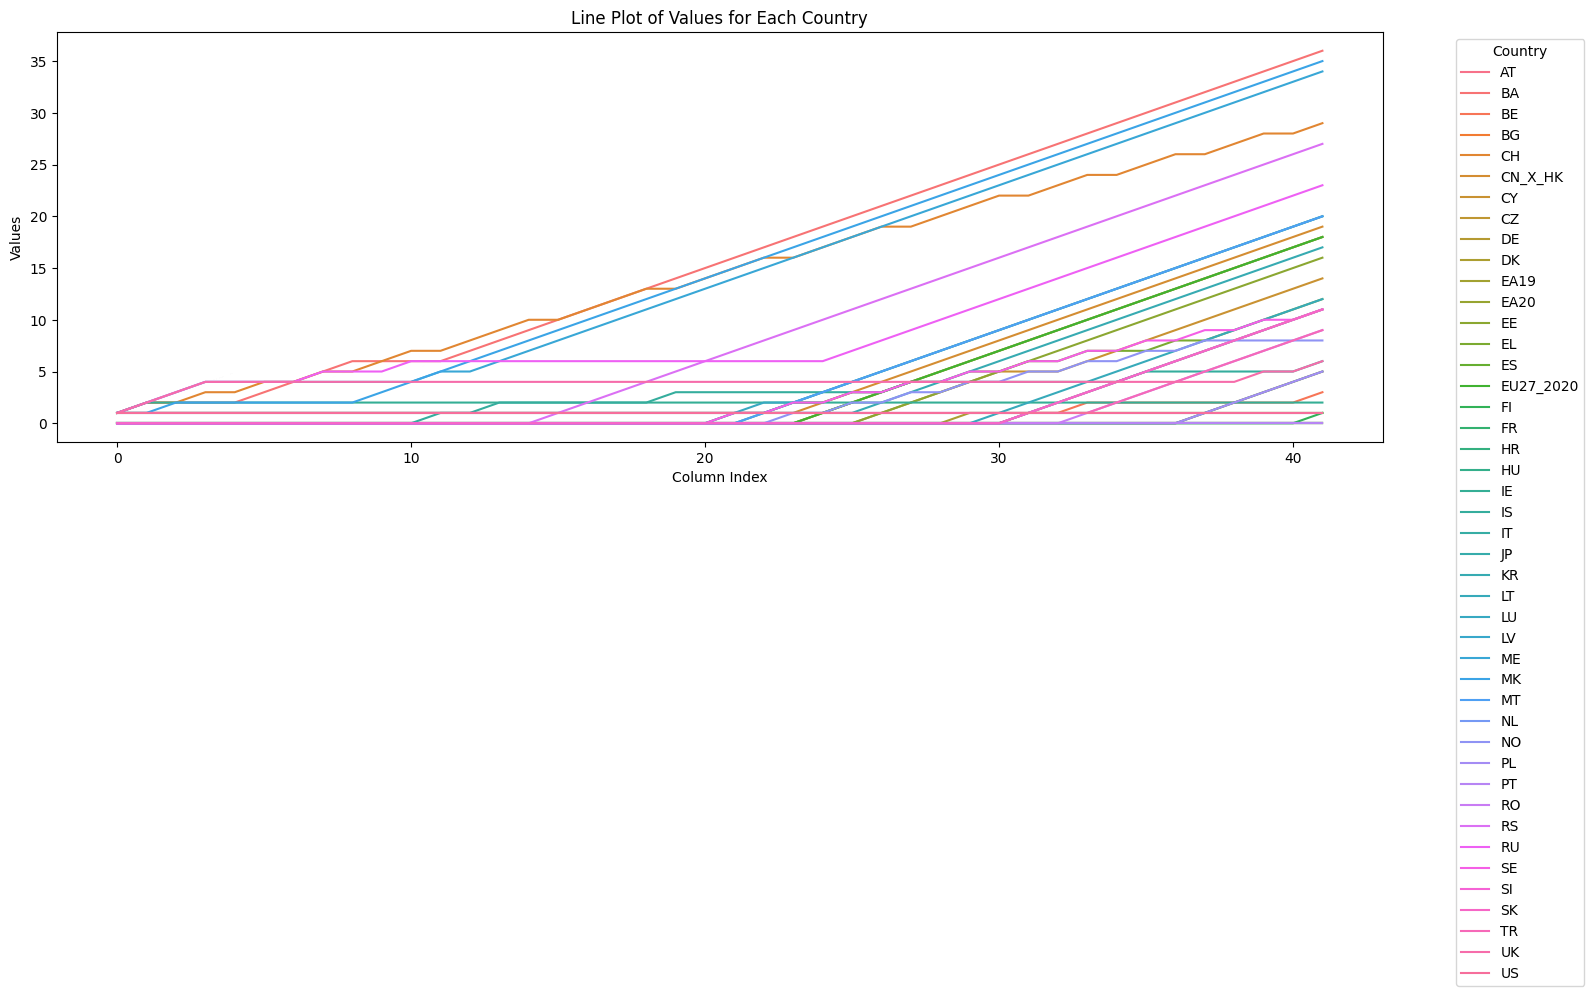

In [4]:
#print(dataBySector.head())

missingValuesPerCountryAndTimeSpan = pd.DataFrame(getMissingDataForTimespan(dataBySector, time_span, []) for time_span in range(1, 43))
missingValuesPerCountryAndTimeSpan = missingValuesPerCountryAndTimeSpan.T
#print(missingValuesPerCountryAndTimeSpan)

missingValuesPerCountryAndTimeSpan.reset_index(inplace=True)
missingValuesPerCountryAndTimeSpan.rename(columns={'index': 'Country'}, inplace=True)


data_melted = missingValuesPerCountryAndTimeSpan.melt(id_vars='Country', var_name='Column', value_name='Value')

plt.figure(figsize=(16, 8))
sns.lineplot(data=data_melted, x='Column', y='Value', hue='Country')

# Customize plot
plt.title("Line Plot of Values for Each Country")
plt.xlabel("Column Index")
plt.ylabel("Values")
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# Decisions so far
Based on the analysis so far, a suitable range for continuing would be a timespan of somewhere between 20 and 25 years. This is the timespan, where the share of missing values is quite small, but the timeframe itself is not to little.

# Analysis Patent Applications


    freq    unit geo\TIME_PERIOD  1978_value 1978_flag  1979_value 1979_flag  \
285    A  P_MHAB              AT         NaN         :       35.12             
286    A  P_MHAB              AU         NaN         :       11.52             
287    A  P_MHAB              BE         NaN         :       25.18             
288    A  P_MHAB              BG         NaN         :         NaN         :   
289    A  P_MHAB              BR         NaN         :        0.12             
290    A  P_MHAB              CA         NaN         :        5.94             
291    A  P_MHAB              CH         NaN         :      141.22             
292    A  P_MHAB              CY         NaN         :         NaN         :   
293    A  P_MHAB              CZ         NaN         :         NaN         :   
294    A  P_MHAB              DE         NaN         :       81.31             
295    A  P_MHAB              DK         NaN         :       21.54             
296    A  P_MHAB            EA18        

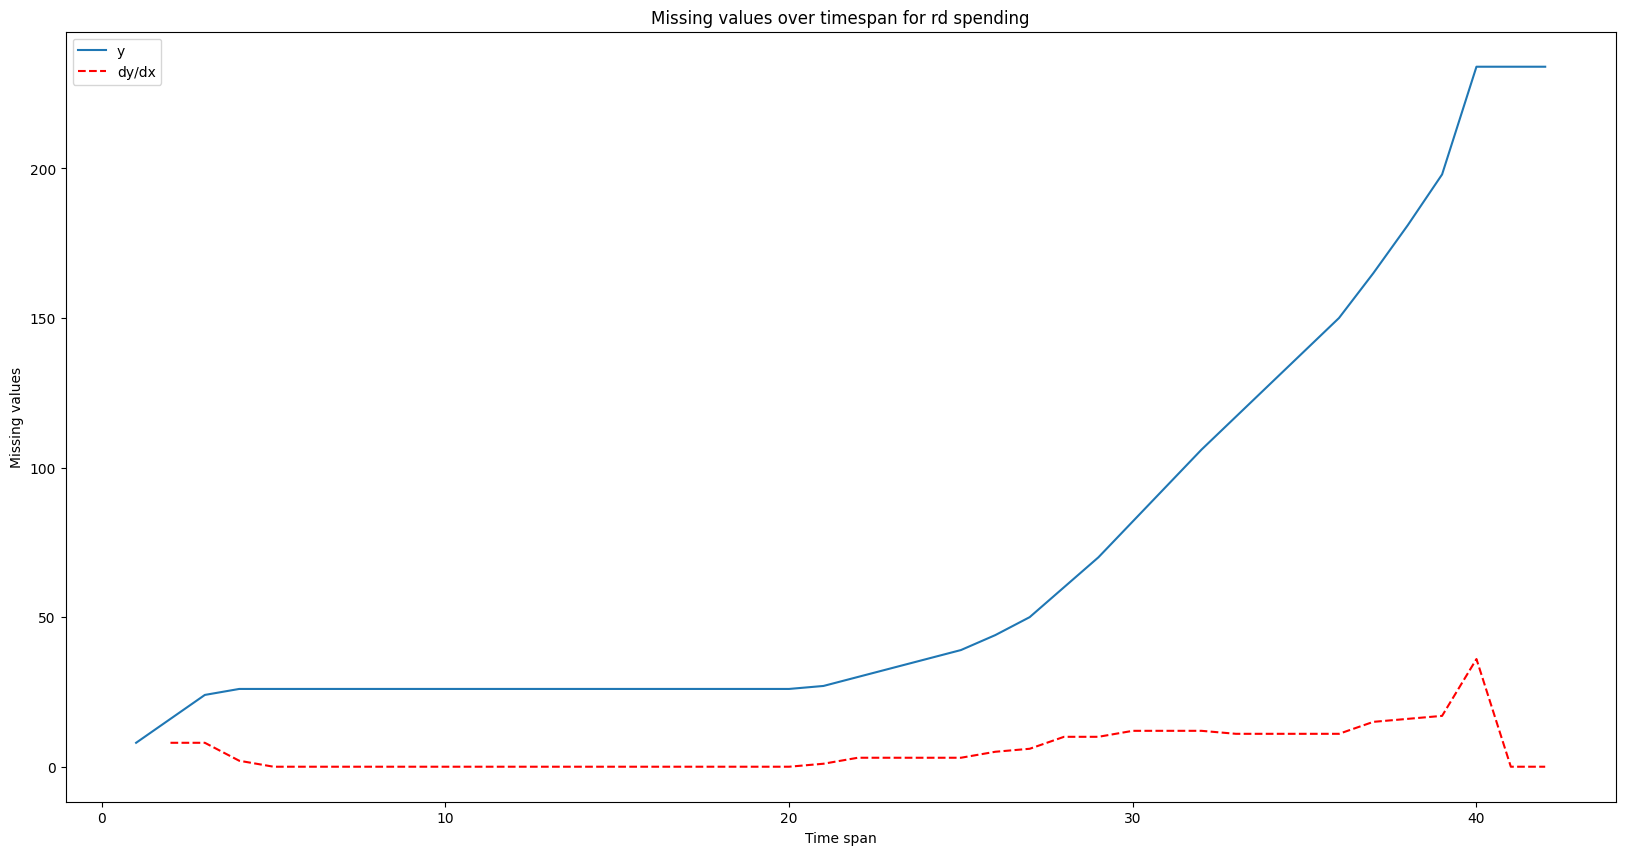

   x   y  y_total  rel_missing_values  dy/dx
0  1   8       48            0.166667    NaN
1  2  16       96            0.166667    8.0
2  3  24      144            0.166667    8.0
3  4  26      192            0.135417    2.0
4  5  26      240            0.108333    0.0


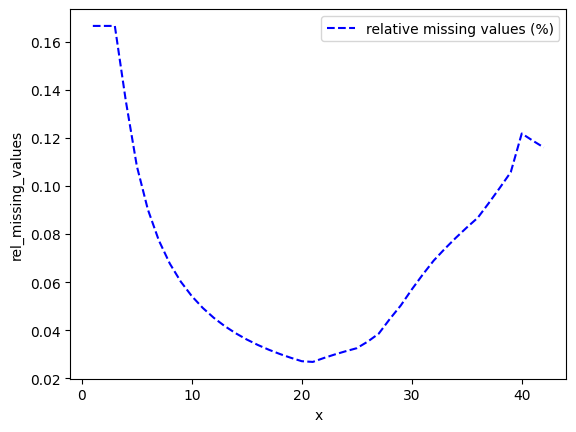

In [5]:
#print(PAT_APPLICATIONS_HIST.head())
unit = "P_MHAB"
sector = "Total"
filteredPatentApplications = PAT_APPLICATIONS_HIST[(PAT_APPLICATIONS_HIST["unit"] == unit)]

print(filteredPatentApplications)


plotData = pd.DataFrame()
#add columns x and y
plotData["x"] = range(1, 43)
plotData["y"] = [sum(getMissingDataForTimespan(filteredPatentApplications, time_span, []).values()) for time_span in range(1, 43)]
#plotData["total_y"] = [sum(dataBySector.)]
plotData["y_total"] = [time_span * len(filteredPatentApplications["geo\TIME_PERIOD"].unique()) for time_span in range(1, 43)]
plotData["rel_missing_values"] = plotData["y"] / plotData["y_total"]


# Calculate the derivative (numerical approximation)
plotData["dy/dx"] = plotData["y"].diff()

# Plotting the data and its derivative
plt.figure(figsize=(20, 10))

# Plot the original data
sns.lineplot(data=plotData, x="x", y="y", label="y")

# Plot the derivative
sns.lineplot(data=plotData, x="x", y="dy/dx", label="dy/dx", linestyle="--", color="red")




plt.xlabel("Time span")
plt.ylabel("Missing values")
plt.title("Missing values over timespan for rd spending")
plt.legend()
plt.show()

print(plotData.head())
sns.lineplot(data=plotData, x="x", y="rel_missing_values", label="relative missing values (%)", linestyle="--", color="blue")
plt.show()

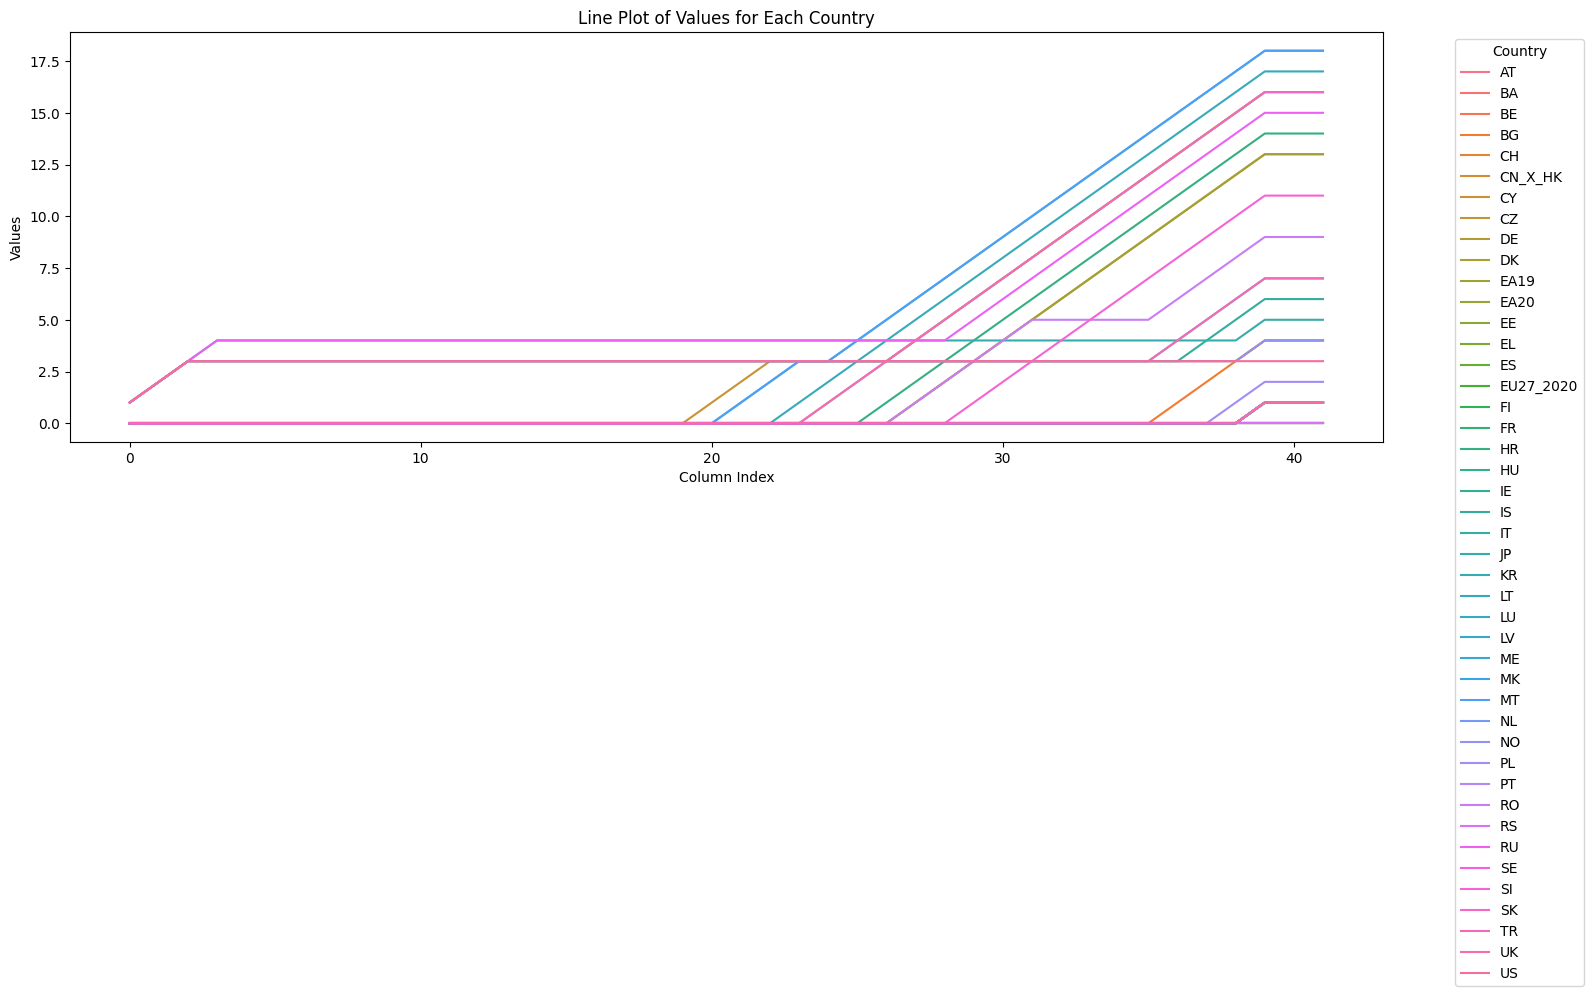

In [6]:
#print(dataBySector.head())

missingValuesPerCountryAndTimeSpan = pd.DataFrame(getMissingDataForTimespan(filteredPatentApplications, time_span, []) for time_span in range(1, 43))
missingValuesPerCountryAndTimeSpan = missingValuesPerCountryAndTimeSpan.T
#print(missingValuesPerCountryAndTimeSpan)

missingValuesPerCountryAndTimeSpan.reset_index(inplace=True)
missingValuesPerCountryAndTimeSpan.rename(columns={'index': 'Country'}, inplace=True)


data_melted = missingValuesPerCountryAndTimeSpan.melt(id_vars='Country', var_name='Column', value_name='Value')

plt.figure(figsize=(16, 8))
sns.lineplot(data=data_melted, x='Column', y='Value', hue='Country')

# Customize plot
plt.title("Line Plot of Values for Each Country")
plt.xlabel("Column Index")
plt.ylabel("Values")
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Decisions on Patent Applications
Also here the most optimal range of values seems to be somewhat between 20 and 25 years in the past. 

# Data Preprocessing
Now, after we did some upfront analysis, we will continue with preparing a suitable dataset for further analysis.

## R&D spending
Let's start with the R&D spending.

In [7]:
sector = "TOTAL"
unit1 = "EUR_HAB"
unit2 = "PC_GDP"
year = 2024 - 25

#Filter Sector and units
RD_filtered = RD_EXP_BY_SECTOR[(RD_EXP_BY_SECTOR["sectperf"] == sector) & ((RD_EXP_BY_SECTOR["unit"] == unit1) | (RD_EXP_BY_SECTOR["unit"] == unit2))]

#Drop unnecessary columns and rename columns
RD_filtered.drop(columns=["freq", "sectperf"], inplace=True)
RD_filtered.rename(columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True)

#Change to long format for further preprocessing
RD_long = RD_filtered.melt(
    id_vars=["Country", "Unit"],
    var_name="Year_Indicator",
    value_name="Value"
)

#Split year and indicator
RD_long[["Year", "Indicator"]] = RD_long["Year_Indicator"].str.split("_", expand=True)
RD_long.drop(columns=["Year_Indicator"], inplace=True)
RD_long["Year"] = pd.to_numeric(RD_long["Year"])

#Filter to relevant time range
RD_long  = RD_long[RD_long["Year"] >= year]


#Rename the different units
RD_long["Unit"].replace({"EUR_HAB": "RD_spend_Euro_per_Inhabitant", "PC_GDP": "RD_spend_Percent_of_GDP"}, inplace=True)

#RD_long.reset_index(drop=True, inplace=True)



#Separate value and flag in two columns
RD_long = RD_long.pivot_table(
    index=["Country", "Year", "Unit"],
    values="Value",
    columns="Indicator",
    aggfunc="first"
)

#Rename to capital letters
RD_long.rename(columns={"value": "Value", "flag": "Flag"}, inplace=True)

#Convert value to numeric value for imputation
RD_long["Value"] = pd.to_numeric(RD_long["Value"])

#Reset index created by pivot
RD_long.reset_index(inplace=True)

#Remove Indicator title for columns
RD_long.columns.name = None

#RD_long.set_index(['Country', 'Year', 'Unit'], inplace=True)
display(RD_long)

/var/folders/m9/jgt_wqqd6b5_pz2y028wb_ww0000gn/T/ipykernel_64201/3907136781.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RD_filtered.drop(columns=["freq", "sectperf"], inplace=True)
/var/folders/m9/jgt_wqqd6b5_pz2y028wb_ww0000gn/T/ipykernel_64201/3907136781.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RD_filtered.rename(columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True)
/var/folders/m9/jgt_wqqd6b5_pz2y028wb_ww0000gn/T/ipykernel_64201/3907136781.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The b

,Country,Year,Unit,Flag,Value
0,AT,1999,RD_spend_Euro_per_Inhabitant,e,471.258
1,AT,1999,RD_spend_Percent_of_GDP,e,1.850
2,AT,2000,RD_spend_Euro_per_Inhabitant,e,503.446
3,AT,2000,RD_spend_Percent_of_GDP,e,1.900
4,AT,2001,RD_spend_Euro_per_Inhabitant,e,547.702
...,...,...,...,...,...
2195,US,2021,RD_spend_Percent_of_GDP,bd,3.480
2196,US,2022,RD_spend_Euro_per_Inhabitant,dp,2628.471
2197,US,2022,RD_spend_Percent_of_GDP,dp,3.590
2198,US,2023,RD_spend_Euro_per_Inhabitant,:,NaN


In [8]:
def plotFlatStruc(df, x, y, hue):
    plt.plot(df[x], df[y], marker='o', linestyle='-', color='b')
    plt.xticks(df[x], rotation=45)
    plt.show()

## Imputation of missing values using interpolation

,Country,Year,Unit,Flag,Value


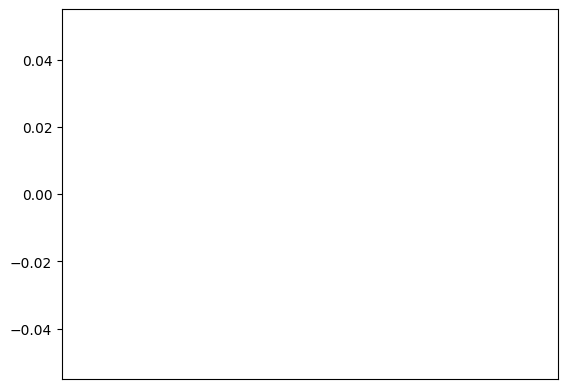

,Country,Year,Unit,Flag,Value


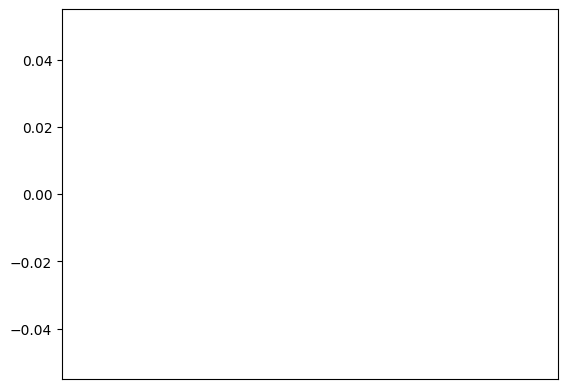

In [9]:
#Impute NaNs

country_to_test = "IS"
unit_to_test = "Percent_of_GDP"
# display(RD_long)

display(RD_long[(RD_long["Unit"] == unit_to_test) & (RD_long["Country"] == country_to_test)])

plotFlatStruc(RD_long[(RD_long["Unit"] == unit_to_test) & (RD_long["Country"] == country_to_test)], x="Year", y="Value", hue="Country")

RD_long["Value"] = RD_long.groupby(by=['Country', 'Unit'])['Value'].transform(lambda group: group.interpolate(method='index'))

display(RD_long[(RD_long["Unit"] == unit_to_test) & (RD_long["Country"] == country_to_test)])

plotFlatStruc(RD_long[(RD_long["Unit"] == unit_to_test) & (RD_long["Country"] == country_to_test)], x="Year", y="Value", hue="Country")



In [10]:
display(RD_long)

,Country,Year,Unit,Flag,Value
0,AT,1999,RD_spend_Euro_per_Inhabitant,e,471.258
1,AT,1999,RD_spend_Percent_of_GDP,e,1.850
2,AT,2000,RD_spend_Euro_per_Inhabitant,e,503.446
3,AT,2000,RD_spend_Percent_of_GDP,e,1.900
4,AT,2001,RD_spend_Euro_per_Inhabitant,e,547.702
...,...,...,...,...,...
2195,US,2021,RD_spend_Percent_of_GDP,bd,3.480
2196,US,2022,RD_spend_Euro_per_Inhabitant,dp,2628.471
2197,US,2022,RD_spend_Percent_of_GDP,dp,3.590
2198,US,2023,RD_spend_Euro_per_Inhabitant,:,2628.471


# Preprocessing Patent Applications

## Historical Data (1999-2004)

In [11]:
unit1 = "P_MHAB"
#unit2 = "PC_GDP"
year = 2024 - 25

#Filter Sector and units
PAT_hist_filtered = PAT_APPLICATIONS_HIST[(PAT_APPLICATIONS_HIST["unit"] == unit1)]

#Drop unnecessary columns and rename columns
PAT_hist_filtered.drop(columns=["freq"], inplace=True)

PAT_hist_filtered.rename(columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True)

# #Change to long format for further preprocessing
PAT_hist_long = PAT_hist_filtered.melt(
    id_vars=["Country", "Unit"],
    var_name="Year_Indicator",
    value_name="Value"
)

#Split year and indicator
PAT_hist_long[["Year", "Indicator"]] = PAT_hist_long["Year_Indicator"].str.split("_", expand=True)

PAT_hist_long.drop(columns=["Year_Indicator"], inplace=True)
PAT_hist_long["Year"] = pd.to_numeric(PAT_hist_long["Year"])

#Filter to relevant time range
PAT_hist_long  = PAT_hist_long[(PAT_hist_long["Year"] >= year) & (PAT_hist_long["Year"] <= 2003)]

#Rename the different units
PAT_hist_long["Unit"].replace({"P_MHAB": "Pat_appl_per_million_inhabitants"}, inplace=True)



display(PAT_hist_long)



/var/folders/m9/jgt_wqqd6b5_pz2y028wb_ww0000gn/T/ipykernel_64201/4186937746.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PAT_hist_filtered.drop(columns=["freq"], inplace=True)
/var/folders/m9/jgt_wqqd6b5_pz2y028wb_ww0000gn/T/ipykernel_64201/4186937746.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PAT_hist_filtered.rename(columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True)
/var/folders/m9/jgt_wqqd6b5_pz2y028wb_ww0000gn/T/ipykernel_64201/4186937746.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The be

,Country,Unit,Value,Year,Indicator
2016,AT,Pat_appl_per_million_inhabitants,134.33,1999,value
2017,AU,Pat_appl_per_million_inhabitants,51.5,1999,value
2018,BE,Pat_appl_per_million_inhabitants,131.63,1999,value
2019,BG,Pat_appl_per_million_inhabitants,0.97,1999,value
2020,BR,Pat_appl_per_million_inhabitants,0.74,1999,value
...,...,...,...,...,...
2491,SK,Pat_appl_per_million_inhabitants,,2003,flag
2492,TR,Pat_appl_per_million_inhabitants,,2003,flag
2493,UK,Pat_appl_per_million_inhabitants,,2003,flag
2494,US,Pat_appl_per_million_inhabitants,,2003,flag


## New Data (2004 - 2023)

In [12]:
unit1 = "P_MHAB"
coop = "APPL"

#Filter Sector and units
PAT_new_filtered = PAT_APPLICATIONS_NEW[(PAT_APPLICATIONS_NEW["unit"] == unit1) & (PAT_APPLICATIONS_NEW["coop_ptn"] == coop)]

#Drop unnecessary columns and rename columns
PAT_new_filtered.drop(columns=["freq", "coop_ptn"], inplace=True)

PAT_new_filtered.rename(columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True)

# #Change to long format for further preprocessing
PAT_new_long = PAT_new_filtered.melt(
    id_vars=["Country", "Unit"],
    var_name="Year_Indicator",
    value_name="Value"
)

#Split year and indicator
PAT_new_long[["Year", "Indicator"]] = PAT_new_long["Year_Indicator"].str.split("_", expand=True)

PAT_new_long.drop(columns=["Year_Indicator"], inplace=True)


PAT_new_long["Year"] = pd.to_numeric(PAT_new_long["Year"])

#Filter to relevant time range
PAT_new_long  = PAT_new_long[(PAT_new_long["Year"] >= 2004)]

#Rename the different units
PAT_new_long["Unit"].replace({"P_MHAB": "Pat_appl_per_million_inhabitants"}, inplace=True)

display(PAT_new_long)

/var/folders/m9/jgt_wqqd6b5_pz2y028wb_ww0000gn/T/ipykernel_64201/3614227721.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PAT_new_filtered.drop(columns=["freq", "coop_ptn"], inplace=True)
/var/folders/m9/jgt_wqqd6b5_pz2y028wb_ww0000gn/T/ipykernel_64201/3614227721.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PAT_new_filtered.rename(columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True)
/var/folders/m9/jgt_wqqd6b5_pz2y028wb_ww0000gn/T/ipykernel_64201/3614227721.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace meth

,Country,Unit,Value,Year,Indicator
0,AL,Pat_appl_per_million_inhabitants,NaN,2004,value
1,AT,Pat_appl_per_million_inhabitants,122.37,2004,value
2,BA,Pat_appl_per_million_inhabitants,NaN,2004,value
3,BE,Pat_appl_per_million_inhabitants,143.27,2004,value
4,BG,Pat_appl_per_million_inhabitants,2.07,2004,value
...,...,...,...,...,...
1515,RS,Pat_appl_per_million_inhabitants,bp,2023,flag
1516,SE,Pat_appl_per_million_inhabitants,p,2023,flag
1517,SI,Pat_appl_per_million_inhabitants,p,2023,flag
1518,SK,Pat_appl_per_million_inhabitants,p,2023,flag


## Combinining Historical and Current

In [13]:
PAT_comb_long = pd.concat([PAT_hist_long, PAT_new_long], axis=0)
PAT_comb_long.reset_index(drop=True, inplace=True)



#Separate value and flag in two columns
PAT_comb_long = PAT_comb_long.pivot_table(
     index=["Country", "Year", "Unit"],
     values="Value",
     columns="Indicator",
     aggfunc="first"
)


#Rename to capital letters
PAT_comb_long.rename(columns={"value": "Value", "flag": "Flag"}, inplace=True)

#Convert value to numeric value for imputation
PAT_comb_long["Value"] = pd.to_numeric(PAT_comb_long["Value"])

#Reset index created by pivot
PAT_comb_long.reset_index(inplace=True)

#Remove Indicator title for columns
PAT_comb_long.columns.name = None

PAT_new_long["Year"] = pd.to_numeric(PAT_new_long["Year"])


#RD_long.set_index(['Country', 'Year', 'Unit'], inplace=True)

display(PAT_comb_long)


,Country,Year,Unit,Flag,Value
0,AL,2004,Pat_appl_per_million_inhabitants,:,NaN
1,AL,2005,Pat_appl_per_million_inhabitants,:,NaN
2,AL,2006,Pat_appl_per_million_inhabitants,:,NaN
3,AL,2007,Pat_appl_per_million_inhabitants,:,NaN
4,AL,2008,Pat_appl_per_million_inhabitants,:,NaN
...,...,...,...,...,...
995,ZA,1999,Pat_appl_per_million_inhabitants,,3.15
996,ZA,2000,Pat_appl_per_million_inhabitants,,3.28
997,ZA,2001,Pat_appl_per_million_inhabitants,,2.66
998,ZA,2002,Pat_appl_per_million_inhabitants,,2.86


## Imputation of missing Values


,Country,Year,Unit,Flag,Value
50,BA,2004,Pat_appl_per_million_inhabitants,:,NaN
51,BA,2005,Pat_appl_per_million_inhabitants,:,NaN
52,BA,2006,Pat_appl_per_million_inhabitants,:,NaN
53,BA,2007,Pat_appl_per_million_inhabitants,:,NaN
54,BA,2008,Pat_appl_per_million_inhabitants,:,NaN
55,BA,2009,Pat_appl_per_million_inhabitants,,0.26
56,BA,2010,Pat_appl_per_million_inhabitants,,0.52
57,BA,2011,Pat_appl_per_million_inhabitants,,0.00
58,BA,2012,Pat_appl_per_million_inhabitants,,0.78
59,BA,2013,Pat_appl_per_million_inhabitants,,0.26


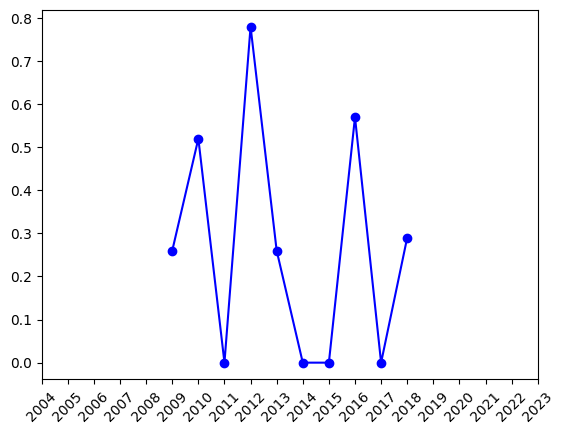

,Country,Year,Unit,Flag,Value
50,BA,2004,Pat_appl_per_million_inhabitants,:,NaN
51,BA,2005,Pat_appl_per_million_inhabitants,:,NaN
52,BA,2006,Pat_appl_per_million_inhabitants,:,NaN
53,BA,2007,Pat_appl_per_million_inhabitants,:,NaN
54,BA,2008,Pat_appl_per_million_inhabitants,:,NaN
55,BA,2009,Pat_appl_per_million_inhabitants,,0.26
56,BA,2010,Pat_appl_per_million_inhabitants,,0.52
57,BA,2011,Pat_appl_per_million_inhabitants,,0.00
58,BA,2012,Pat_appl_per_million_inhabitants,,0.78
59,BA,2013,Pat_appl_per_million_inhabitants,,0.26


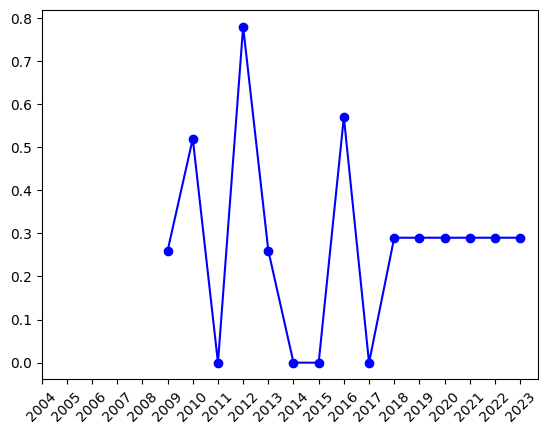

In [14]:
#Impute NaNs

country_to_test = "BA"
unit_to_test = "Pat_appl_per_million_inhabitants"

display(PAT_comb_long[(PAT_comb_long["Unit"] == unit_to_test) & (PAT_comb_long["Country"] == country_to_test)])

plotFlatStruc(PAT_comb_long[(PAT_comb_long["Unit"] == unit_to_test) & (PAT_comb_long["Country"] == country_to_test)], x="Year", y="Value", hue="Country")

PAT_comb_long["Value"] = PAT_comb_long.groupby(by=['Country', 'Unit'])['Value'].transform(lambda group: group.interpolate(method='index'))

display(PAT_comb_long[(PAT_comb_long["Unit"] == unit_to_test) & (PAT_comb_long["Country"] == country_to_test)])

plotFlatStruc(PAT_comb_long[(PAT_comb_long["Unit"] == unit_to_test) & (PAT_comb_long["Country"] == country_to_test)], x="Year", y="Value", hue="Country")




# Merge Dataset

In [20]:
merged_df = pd.concat([RD_long,PAT_comb_long], axis=0)
merged_df.reset_index(drop=True, inplace=True)
merged_df.sort_values(by=["Country", "Year", "Unit"], inplace=True)

merged_df.set_index(["Country", "Year", "Unit"], inplace=True)
display(merged_df)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
  display(merged_df)

Flag  Value
Country Year Unit                                        
AL      2004 Pat_appl_per_million_inhabitants    :    NaN
        2005 Pat_appl_per_million_inhabitants    :    NaN
        2006 Pat_appl_per_million_inhabitants    :    NaN
        2007 Pat_appl_per_million_inhabitants    :    NaN
        2008 Pat_appl_per_million_inhabitants    :    NaN
...                                            ...    ...
ZA      1999 Pat_appl_per_million_inhabitants        3.15
        2000 Pat_appl_per_million_inhabitants        3.28
        2001 Pat_appl_per_million_inhabitants        2.66
        2002 Pat_appl_per_million_inhabitants        2.86
        2003 Pat_appl_per_million_inhabitants        3.19

[3200 rows x 2 columns]

Flag         Value
Country   Year Unit                                               
AL        2004 Pat_appl_per_million_inhabitants    :           NaN
          2005 Pat_appl_per_million_inhabitants    :           NaN
          2006 Pat_appl_per_million_inhabitants    :           NaN
          2007 Pat_appl_per_million_inhabitants    :           NaN
          2008 Pat_appl_per_million_inhabitants    :           NaN
          2009 Pat_appl_per_million_inhabitants           0.340000
          2010 Pat_appl_per_million_inhabitants           0.000000
          2011 Pat_appl_per_million_inhabitants           0.000000
          2012 Pat_appl_per_million_inhabitants           0.000000
          2013 Pat_appl_per_million_inhabitants           0.000000
          2014 Pat_appl_per_million_inhabitants           1.040000
          2015 Pat_appl_per_million_inhabitants           0.000000
          2016 Pat_appl_per_million_inhabitants           0.700000
          2017 Pat_appl_per_million_inhabitants           0.000000
          2018 Pat_appl_per_million_inhabitants           0.000000
          2019 Pat_appl_per_million_inhabitants           0.700000
          2020 Pat_appl_per_million_inhabitants           0.000000
          2021 Pat_appl_per_million_inhabitants           1.070000
          2022 Pat_appl_per_million_inhabitants           2.520000
          2023 Pat_appl_per_million_inhabitants    p      2.900000
AT        1999 Pat_appl_per_million_inhabitants         134.330000
               RD_spend_Euro_per_Inhabitant        e    471.258000
               RD_spend_Percent_of_GDP             e      1.850000
          2000 Pat_appl_per_million_inhabitants         147.860000
               RD_spend_Euro_per_Inhabitant        e    503.446000
               RD_spend_Percent_of_GDP             e      1.900000
          2001 Pat_appl_per_million_inhabitants         149.900000
               RD_spend_Euro_per_Inhabitant        e    547.702000
               RD_spend_Percent_of_GDP             e      2.000000
          2002 Pat_appl_per_million_inhabitants         160.120000
               RD_spend_Euro_per_Inhabitant             580.918000
               RD_spend_Percent_of_GDP                    2.080000
          2003 Pat_appl_per_million_inhabitants         171.880000
               RD_spend_Euro_per_Inhabitant        e    622.446000
               RD_spend_Percent_of_GDP             e      2.190000
          2004 Pat_appl_per_million_inhabitants         122.370000
               RD_spend_Euro_per_Inhabitant             644.704000
               RD_spend_Percent_of_GDP                    2.180000
          2005 Pat_appl_per_million_inhabitants         127.980000
               RD_spend_Euro_per_Inhabitant        e    735.221000
               RD_spend_Percent_of_GDP             e      2.390000
          2006 Pat_appl_per_million_inhabitants         138.600000
               RD_spend_Euro_per_Inhabitant             765.491000
               RD_spend_Percent_of_GDP                    2.380000
          2007 Pat_appl_per_million_inhabitants         166.600000
               RD_spend_Euro_per_Inhabitant             829.147000
               RD_spend_Percent_of_GDP                    2.430000
          2008 Pat_appl_per_million_inhabitants         180.620000
               RD_spend_Euro_per_Inhabitant        e    908.530000
               RD_spend_Percent_of_GDP             e      2.590000
          2009 Pat_appl_per_million_inhabitants         179.310000
               RD_spend_Euro_per_Inhabitant             897.390000
               RD_spend_Percent_of_GDP                    2.610000
          2010 Pat_appl_per_million_inhabitants         208.530000
               RD_spend_Euro_per_Inhabitant        e    965.851000
               RD_spend_Percent_of_GDP             e      2.740000
          2011 Pat_appl_per_million_inhabitants         206.630000
               RD_spend_Euro_per_Inhabitant             988.200000
               RD_spend_Perc

Looks like for a time span sub 20-30 years, the data has not too many missing values. Also the number of missing values starts to increase after a time span of ca 23 years.

Do the same for the patent dataset, and see if the same pattern is observed.

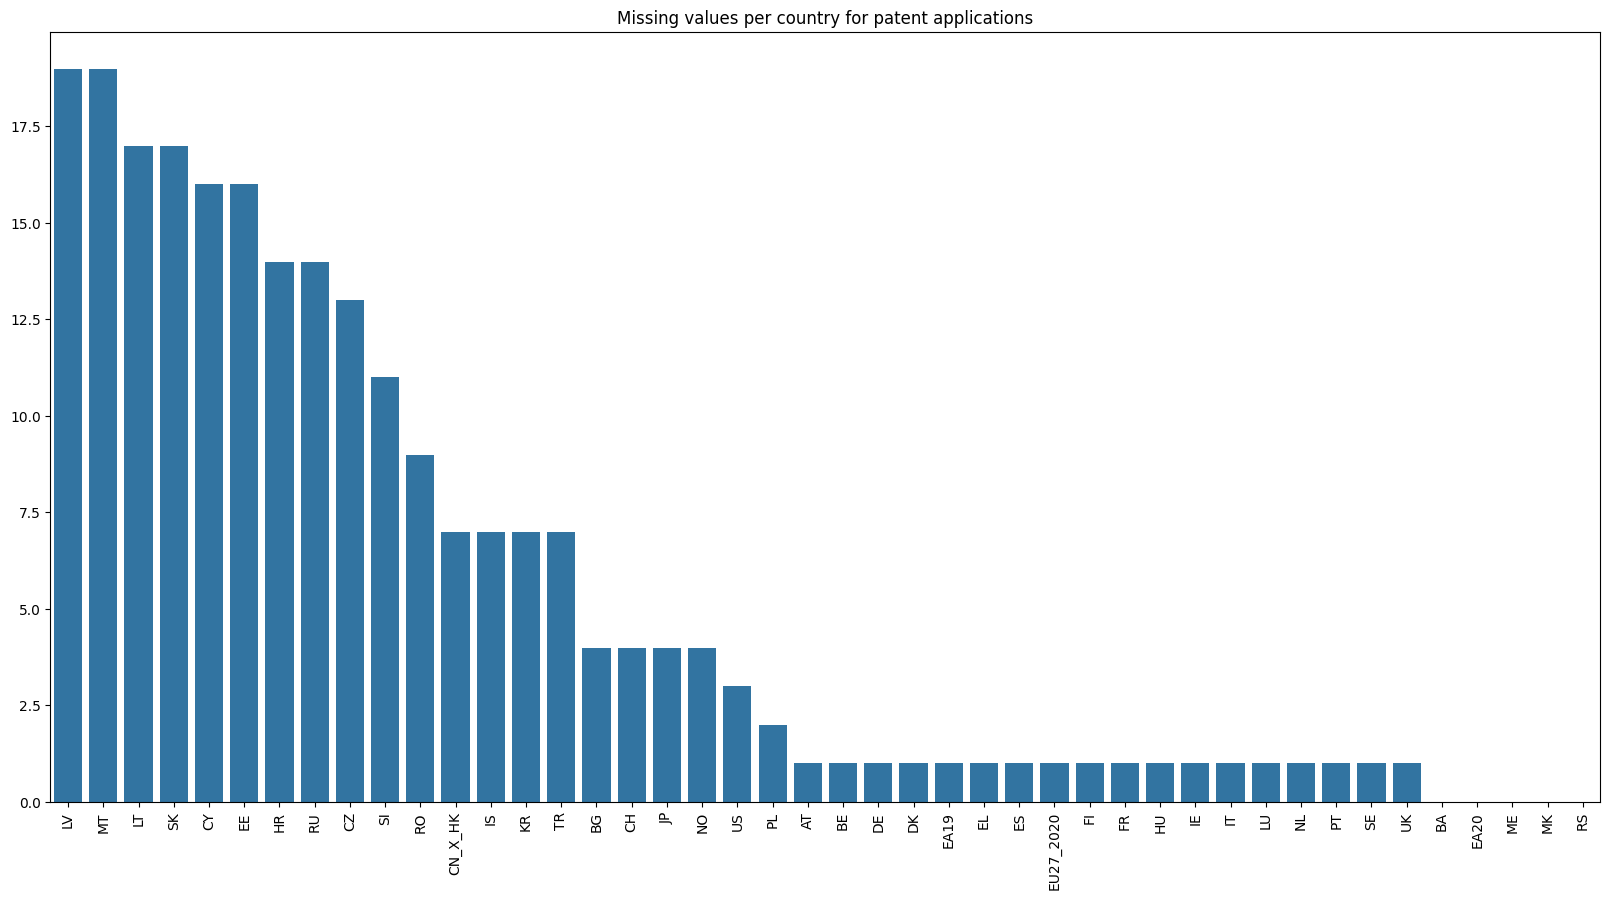

In [16]:
time_span = 43
unit = "NR" #should be enough since we already cleaned the rnd spending data according to inhabitants
data = PAT_APPLICATIONS_HIST[(PAT_APPLICATIONS_HIST["unit"] == unit)]

missingData = getMissingDataForTimespan(data,time_span,[])

missingData = dict(sorted(missingData.items(), key=lambda item: item[1],reverse=True))
plt.figure(figsize=(20,10))
sns.barplot(x=missingData.keys(),y=missingData.values())
plt.xticks(rotation=90)
plt.title("Missing values per country for patent applications")
plt.show()


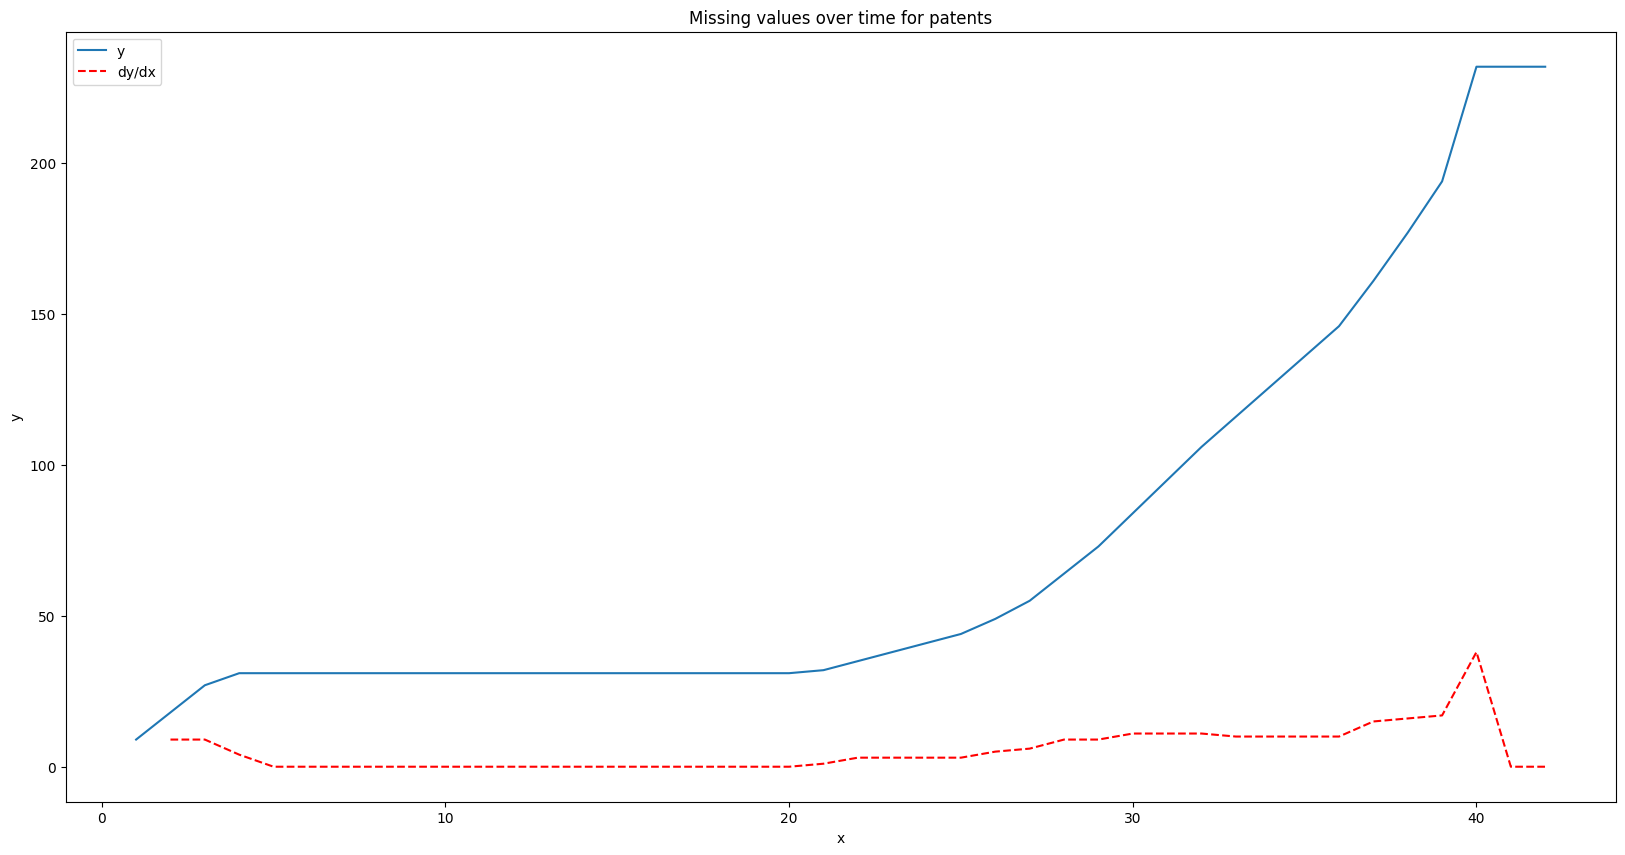

In [17]:
import pandas as pd
plotData = pd.DataFrame()
#add columns x and y
plotData["x"] = range(1, 43)
plotData["y"] = [sum(getMissingDataForTimespan(data, time_span, []).values()) for time_span in range(1, 43)]

# Calculate the derivative (numerical approximation)
plotData["dy/dx"] = plotData["y"].diff()

# Plotting the data and its derivative
plt.figure(figsize=(20, 10))

# Plot the original data
sns.lineplot(data=plotData, x="x", y="y", label="y")

# Plot the derivative
sns.lineplot(data=plotData, x="x", y="dy/dx", label="dy/dx", linestyle="--", color="red")
plt.title("Missing values over time for patents")
plt.legend()
plt.show()

Looks like the patent dataset as good data for the last 20-25 years.

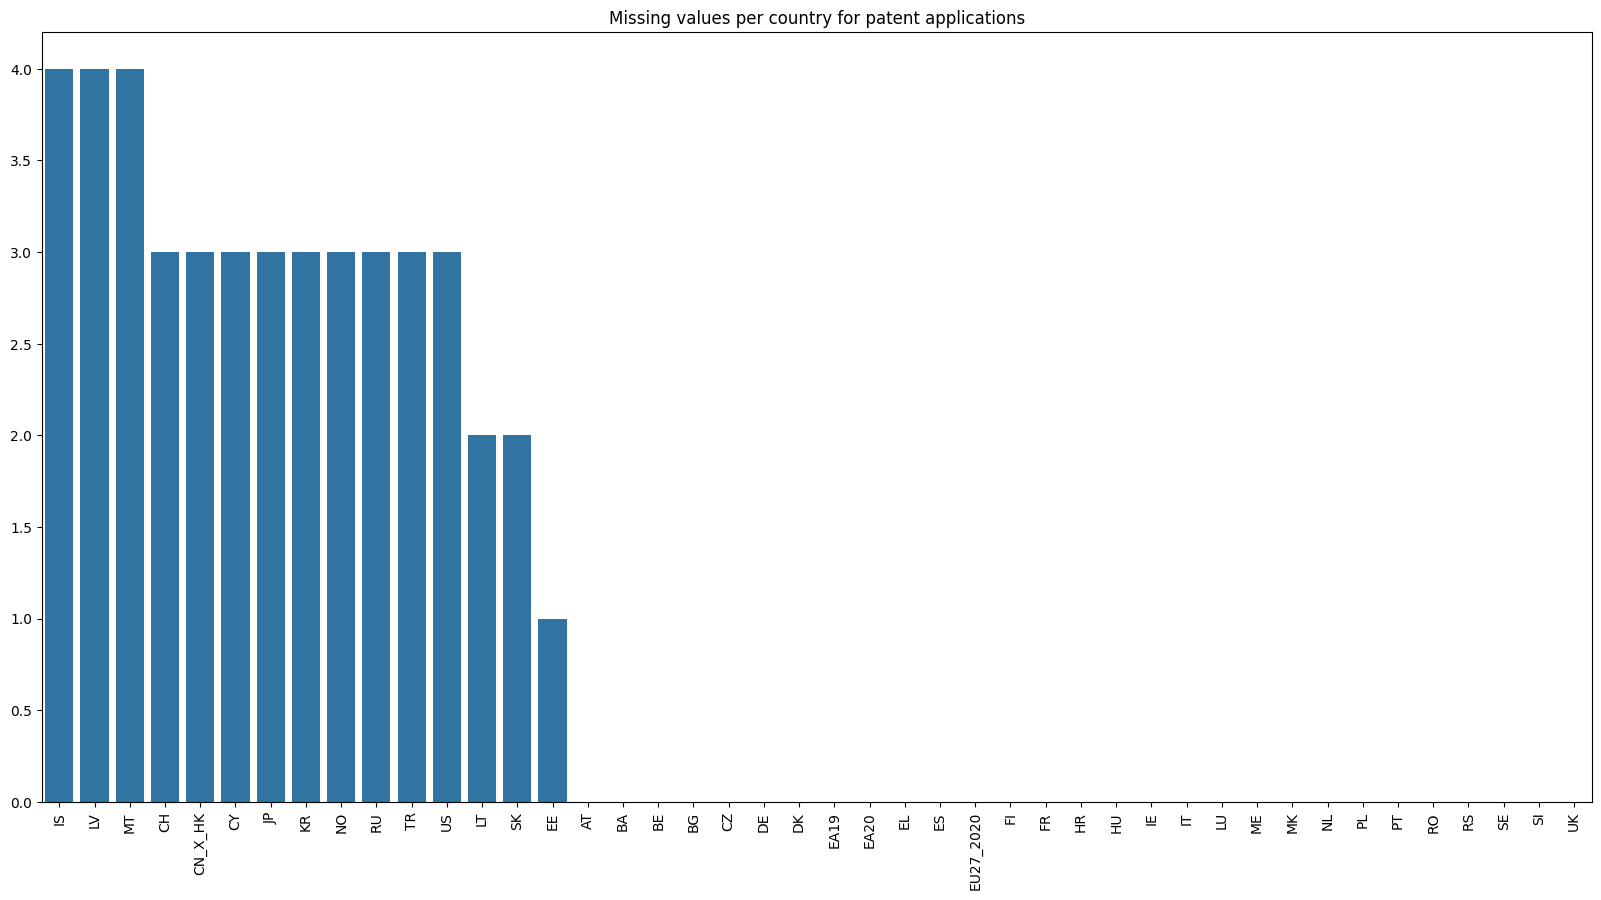

In [18]:
time_span = 25
unit = "NR" #should be enough since we already cleaned the rnd spending data according to inhabitants
data = PAT_APPLICATIONS_HIST[(PAT_APPLICATIONS_HIST["unit"] == unit)]

missingData = getMissingDataForTimespan(data,time_span,[])

missingData = dict(sorted(missingData.items(), key=lambda item: item[1],reverse=True))
plt.figure(figsize=(20,10))
sns.barplot(x=missingData.keys(),y=missingData.values())
plt.xticks(rotation=90)
plt.title("Missing values per country for patent applications")
plt.show()